In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from pandas_datareader import data as pdr
from scipy.stats import norm, t
import matplotlib.pyplot as plt

In [2]:
# Import data
def getData(stocks, start, end):
    stockData = pdr.get_data_yahoo(stocks, start=start, end=end)
    stockData = stockData['Close']
    returns = stockData.pct_change()
    meanReturns = returns.mean()
    covMatrix = returns.cov()
    return returns, meanReturns, covMatrix

# Portfolio Performance
def portfolioPerformance(weights, meanReturns, covMatrix, Time):
    returns = np.sum(meanReturns*weights)*Time
    std = np.sqrt( np.dot(weights.T, np.dot(covMatrix, weights)) ) * np.sqrt(Time)
    return returns, std

stockList = ['CBA', 'BHP', 'TLS', 'NAB', 'WBC', 'STO']
stocks = [stock+'.AX' for stock in stockList]
endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days=800)

returns, meanReturns, covMatrix = getData(stocks, start=startDate, end=endDate)
returns = returns.dropna() # normalise weights

weights = np.random.random(len(returns.columns))
weights /= np.sum(weights)

returns['portfolio'] = returns.dot(weights)

#### Historical VaR

In [22]:
def historicalVaR(returns, alpha=5):
    """
    Read in a pandas dataframe of returns / a pandas series of returns
    Output the percentile of the distribution at the given alpha confidence level
    """
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    # A passed user-defined-function will be passed a Series for evaluation.
    elif isinstance(returns, pd.DataFrame):
        return returns.aggregate(historicalVaR, alpha=alpha)
    else:
        raise TypeError("Expected returns to be dataframe or series")


def historicalCVaR(returns, alpha=5):
    """
    Read in a pandas dataframe of returns / a pandas series of returns
    Output the CVaR for dataframe / series
    """
    if isinstance(returns, pd.Series):
        belowVaR = returns <= historicalVaR(returns, alpha=alpha)
        return returns[belowVaR].mean()
    # A passed user-defined-function will be passed a Series for evaluation.
    elif isinstance(returns, pd.DataFrame):
        return returns.aggregate(historicalCVaR, alpha=alpha)
    else:
        raise TypeError("Expected returns to be dataframe or series")
        
Time = 100
hVaR = historicalVaR(returns['portfolio'], alpha=5)*np.sqrt(Time)
hCVaR = historicalCVaR(returns['portfolio'], alpha=5)*np.sqrt(Time)
pRet, pStd = portfolioPerformance(weights, meanReturns, covMatrix, Time)
InitialInvestment = 10000
print('Expected Portfolio Return:      ', round(InitialInvestment*pRet,2))
print('Value at Risk 95th CI    :      ', round(InitialInvestment*hVaR,2))
print('Conditional VaR 95th CI  :      ', round(InitialInvestment*hCVaR,2))

Expected Portfolio Return:       762.87
Value at Risk 95th CI    :       -1945.81
Conditional VaR 95th CI  :       -2578.79


#### Parametric VaR

In [23]:
def var_parametric(portofolioReturns, portfolioStd, distribution='normal', alpha=5, dof=6):
    # because the distribution is symmetric
    if distribution == 'normal':
        VaR = norm.ppf(1-alpha/100)*portfolioStd - portofolioReturns
    elif distribution == 't-distribution':
        nu = dof
        VaR = np.sqrt((nu-2)/nu) * t.ppf(1-alpha/100, nu) * portfolioStd - portofolioReturns
    else:
        raise TypeError("Expected distribution type 'normal'/'t-distribution'")
    return VaR

def cvar_parametric(portofolioReturns, portfolioStd, distribution='normal', alpha=5, dof=6):
    if distribution == 'normal':
        CVaR = (alpha/100)**-1 * norm.pdf(norm.ppf(alpha/100))*portfolioStd - portofolioReturns
    elif distribution == 't-distribution':
        nu = dof
        xanu = t.ppf(alpha/100, nu)
        CVaR = -1/(alpha/100) * (1-nu)**(-1) * (nu-2+xanu**2) * t.pdf(xanu, nu) * portfolioStd - portofolioReturns
    else:
        raise TypeError("Expected distribution type 'normal'/'t-distribution'")
    return CVaR

normVaR = var_parametric(pRet, pStd)
normCVaR = cvar_parametric(pRet, pStd)

tVaR = var_parametric(pRet, pStd, distribution='t-distribution')
tCVaR = cvar_parametric(pRet, pStd, distribution='t-distribution')

print("Normal VaR 95th CI       :      ", round(InitialInvestment*normVaR,2))
print("Normal CVaR 95th CI      :      ", round(InitialInvestment*normCVaR,2))
print("t-dist VaR 95th CI       :      ", round(InitialInvestment*tVaR,2))
print("t-dist CVaR 95th CI      :      ", round(InitialInvestment*tCVaR,2))

Normal VaR 95th CI       :       1209.29
Normal CVaR 95th CI      :       1710.3
t-dist VaR 95th CI       :       1139.45
t-dist CVaR 95th CI      :       1822.35


#### Monte Carlo VaR

In [25]:
# Monte Carlo Method
mc_sims = 400 # number of simulations
T = 100 #timeframe in days

meanM = np.full(shape=(T, len(weights)), fill_value=meanReturns)
meanM = meanM.T

portfolio_sims = np.full(shape=(T, mc_sims), fill_value=0.0)

initialPortfolio = 10000

for m in range(0, mc_sims):
    # MC loops
    Z = np.random.normal(size=(T, len(weights)))
    L = np.linalg.cholesky(covMatrix)
    dailyReturns = meanM + np.inner(L, Z)
    portfolio_sims[:,m] = np.cumprod(np.inner(weights, dailyReturns.T)+1)*initialPortfolio

<function matplotlib.pyplot.show(close=None, block=None)>

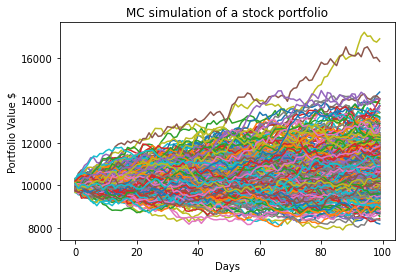

In [26]:
plt.plot(portfolio_sims)
plt.ylabel('Portfolio Value $')
plt.xlabel('Days')
plt.title('MC simulation of a stock portfolio')
plt.show

In [27]:
def mcVaR(returns, alpha=5):
    """ Input: pandas series of returns
        Output: percentile on return distribution to a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    else:
        raise TypeError("Expected a pandas data series.")

def mcCVaR(returns, alpha=5):
    """ Input: pandas series of returns
        Output: CVaR or Expected Shortfall to a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        belowVaR = returns <= mcVaR(returns, alpha=alpha)
        return returns[belowVaR].mean()
    else:
        raise TypeError("Expected a pandas data series.")

In [28]:
portResults = pd.Series(portfolio_sims[-1,:])

VaR = initialPortfolio - mcVaR(portResults, alpha=5)
CVaR = initialPortfolio - mcCVaR(portResults, alpha=5)

print('VaR ${}'.format(round(VaR,2)))
print('CVaR ${}'.format(round(CVaR,2)))

VaR $1092.52
CVaR $1323.74


#### Comparing Each VaR Model

In [30]:
print("\nVaR:")
print(' Historical VaR 95th CI   :      ', round(InitialInvestment*hVaR,2))
print(" Parametric VaR 95th CI       :      ", round(InitialInvestment*normVaR,2))
print(" t-dist VaR 95th CI       :      ", round(InitialInvestment*tVaR,2))
print(" MC VaR  95th CI          :      ", round(VaR,2))
print("\nCVaR:")
print(' Historical CVaR 95th CI  :      ', round(InitialInvestment*hCVaR,2))
print(" Parametric CVaR 95th CI      :      ", round(InitialInvestment*normCVaR,2))
print(" t-dist CVaR 95th CI      :      ", round(InitialInvestment*tCVaR,2))
print(" MC CVaR 95th CI          :      ", round(CVaR,2))


VaR:
 Historical VaR 95th CI   :       -1945.81
 Parametric VaR 95th CI       :       1209.29
 t-dist VaR 95th CI       :       1139.45
 MC VaR  95th CI          :       1092.52

CVaR:
 Historical CVaR 95th CI  :       -2578.79
 Parametric CVaR 95th CI      :       1710.3
 t-dist CVaR 95th CI      :       1822.35
 MC CVaR 95th CI          :       1323.74
